In [18]:
#Temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Zaman serisi analizleri için
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Model kurma için
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [19]:
# AirPassengers veri setini yükleyelim
df = pd.read_csv('AirPassengers.csv')

# Sütun adını düzeltelim (bazen '#Passengers' olarak geliyor)
if '#Passengers' in df.columns:
    df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
   
# Tarih indeksini ayarlayalım
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [20]:
# Veri setine göz atalım
print("Veri seti özeti:")
print(f"  Gözlem sayısı: {len(df)}")
print(f"  Tarih aralığı: {df.index.min()} - {df.index.max()}")

Veri seti özeti:
  Gözlem sayısı: 144
  Tarih aralığı: 1949-01-01 00:00:00 - 1960-12-01 00:00:00


In [21]:
print(f"\n{df.head()}")


            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


In [22]:
print(f"\n{df.tail()}")


            Passengers
Month                 
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432


In [23]:
print(f"\nTemel istatistikler:\n{df.describe()}")


Temel istatistikler:
       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


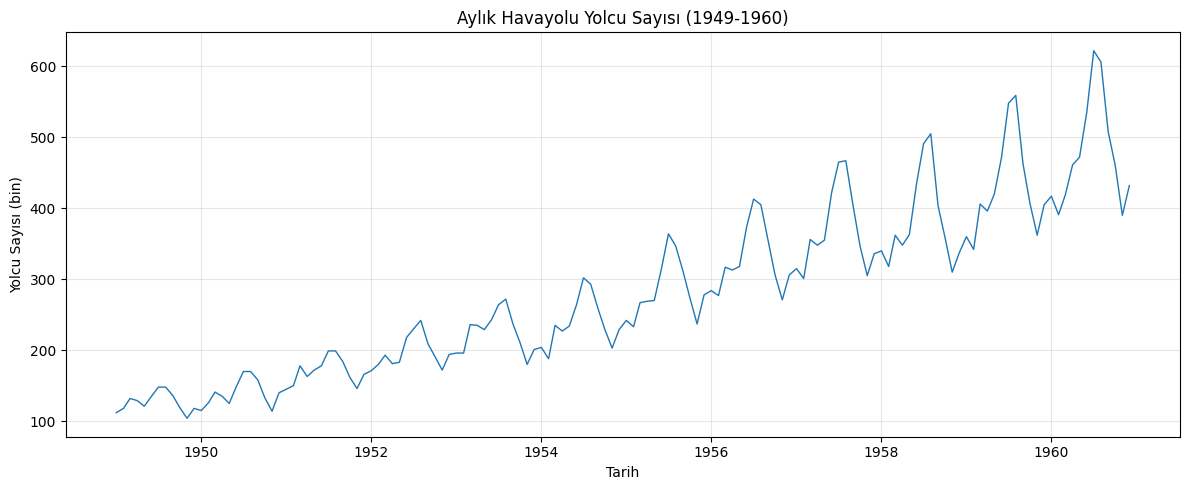

In [24]:
# Seriyi çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Passengers'], linewidth=1)
plt.title('Aylık Havayolu Yolcu Sayısı (1949-1960)')
plt.xlabel('Tarih')
plt.ylabel('Yolcu Sayısı (bin)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

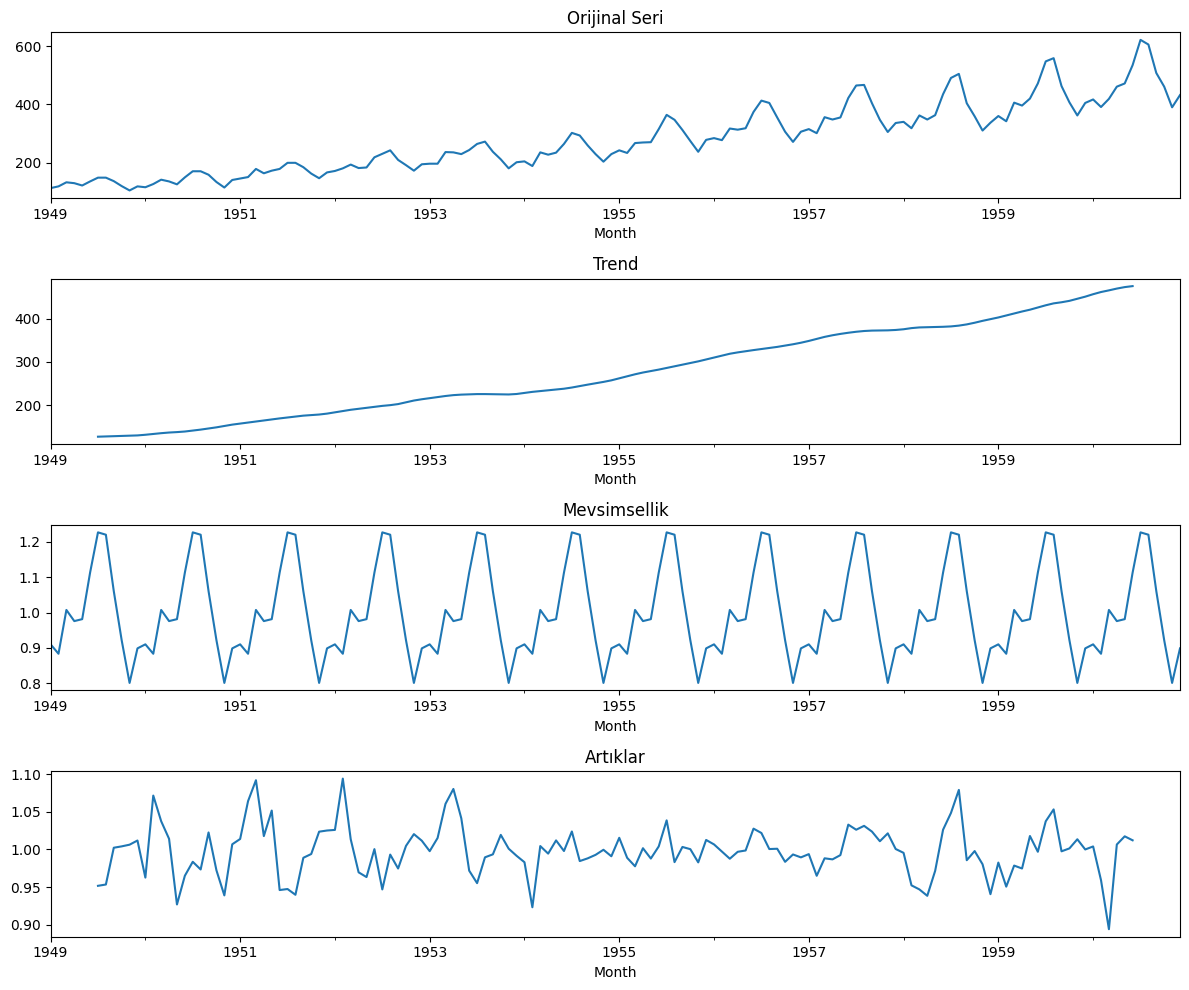

In [25]:
#Bileşenlere ayırma
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative')

fig, axes = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=axes[0], title='Orijinal Seri')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title='Mevsimsellik')
decomposition.resid.plot(ax=axes[3], title='Artıklar')
plt.tight_layout()
plt.show()


In [26]:
#ADF testi uygulayalım ve sonuçları yorumlayalım.
def adf_test(series, name=''):
    result = adfuller(series.dropna(), autolag='AIC')

    print(f"\n{name} - ADF Testi Sonuçları:")
    print(f"  Test İstatistiği: {result[0]:.4f}")
    print(f"  p-değeri: {result[1]:.4f}")
    print(f"  Kritik Değerler:")
    
    for key, value in result[4].items():
            print(f"    {key}: {value:.4f}")
        
    if result[1] < 0.05:
            print("  → Seri durağan (H0 reddedildi)")
    else:
            print("  → Seri durağan değil (H0 reddedilemedi)")
        
    return result[1]

# Test edelim
adf_test(df['Passengers'], "Orijinal Seri")


Orijinal Seri - ADF Testi Sonuçları:
  Test İstatistiği: 0.8154
  p-değeri: 0.9919
  Kritik Değerler:
    1%: -3.4817
    5%: -2.8840
    10%: -2.5788
  → Seri durağan değil (H0 reddedilemedi)


np.float64(0.991880243437641)

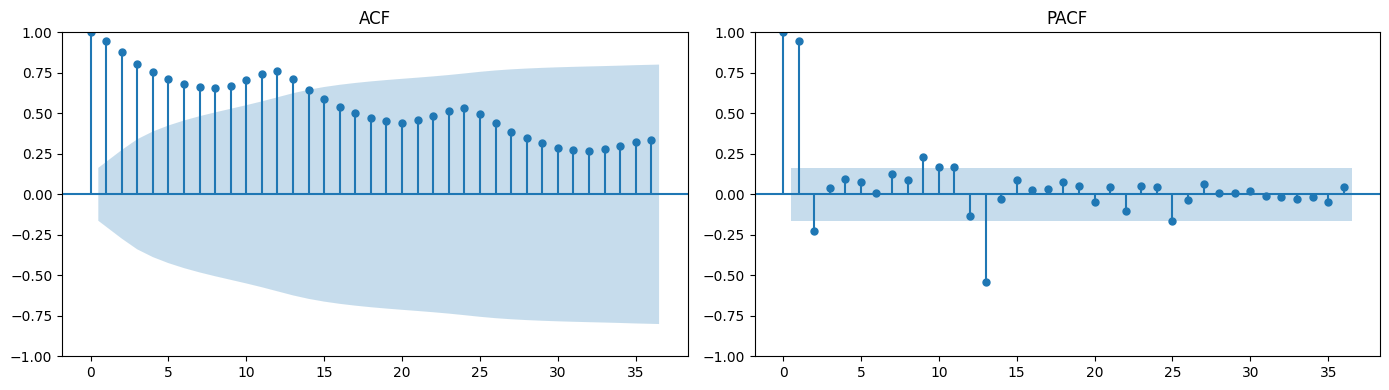

In [27]:
#ACF ve PACF grafiklerini çizdirelim
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df['Passengers'], lags=36, ax=axes[0])
axes[0].set_title('ACF')

plot_pacf(df['Passengers'], lags=36, ax=axes[1])
axes[1].set_title('PACF')

plt.tight_layout()
plt.show()

In [28]:
from pmdarima import auto_arima

# Logaritmik dönüşüm uygulayalım (varyans stabilizasyonu için)
log_passengers = np.log(df['Passengers'])

# En iyi modeli otomatik olarak bulalım
model = auto_arima(
    log_passengers,
    seasonal=True,
    m=12,  # Mevsimsel periyot
    trace=True,  # Denenen modelleri göster
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-476.667, Time=1.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-358.005, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-472.836, Time=1.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-423.080, Time=0.49 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-152.756, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-485.488, Time=1.81 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-455.333, Time=0.53 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-483.588, Time=2.66 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-478.497, Time=1.16 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-483.265, Time=3.43 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-486.530, Time=1.42 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-455.568, Time=0.45 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-479.015, Time=1.35 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-485.339, Time=2.26 sec
 ARIMA(1,0,2)(1,1,0

In [29]:
# Son 12 ayı test için ayıralım
train = log_passengers[:-12]
test = log_passengers[-12:]

# Modeli eğitim verisiyle kuralım
model_train = auto_arima(
    train,
    seasonal=True,
    m=12,
    suppress_warnings=True,
    stepwise=True
)

# Tahmin yapalım
predictions = model_train.predict(n_periods=12)

# Orijinal ölçeğe dönüştürelim
test_original = np.exp(test)
predictions_original = np.exp(predictions)

# Performans metrikleri
rmse = np.sqrt(mean_squared_error(test_original, predictions_original))
mae = mean_absolute_error(test_original, predictions_original)
mape = np.mean(np.abs((test_original - predictions_original) / test_original)) * 100

print(f"\nTest Seti Performansı:")
print(f"  RMSE: {rmse:.2f}")
print(f"  MAE:  {mae:.2f}")
print(f"  MAPE: {mape:.2f}%")


Test Seti Performansı:
  RMSE: 23.04
  MAE:  18.32
  MAPE: 3.95%


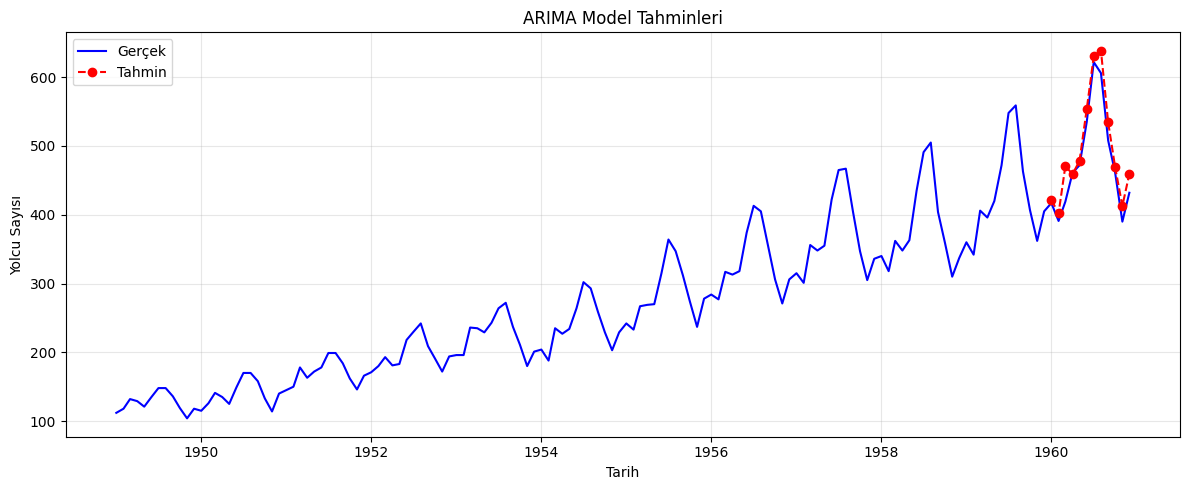

In [30]:
plt.figure(figsize=(12, 5))

# Gerçek değerler
plt.plot(df.index, df['Passengers'], label='Gerçek', color='blue')

# Tahminler
test_dates = df.index[-12:]
plt.plot(test_dates, predictions_original, label='Tahmin', 
         color='red', linestyle='--', marker='o')

plt.title('ARIMA Model Tahminleri')
plt.xlabel('Tarih')
plt.ylabel('Yolcu Sayısı')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()